In [1]:
import lammps
import random
from tqdm import trange
import pymc3 as pm
import arviz as az
import numpy as np
import pymatgen as pmg
import theano.tensor as tt
from copy import deepcopy
import matplotlib.pyplot as plt

# Initialisation
Create a lammps instance and load coordinates.

In [2]:
elements = pmg.Element('Li'), pmg.Element('Ni'), pmg.Element('O')
li, ni, o = elements

pairs = [(li,o), (ni,o), (o,o)]

charges = {li: 1,
           ni: 3,
           o: -2,}

bpp_def = {'Li_O_A'   : 186.432,
           'Li_O_rho' : 0.302,
           'Li_O_C'   : 0.0,
           'Ni_O_A'   : 345.559,
           'Ni_O_rho' : 0.459,
           'Ni_O_C'   : 0.546,
           'O_O_A'    : 22843.828,
           'O_O_rho'  : 0.086,
           'O_O_C'    : 28.354}

bpp = deepcopy(bpp_def)
         
def dex(elin): return elements.index(elin) + 1

In [3]:
def update_potentials(**kwargs):
    bpp.update(kwargs)
def set_potentials():
    for pair in pairs:
        lmp.command('pair_coeff {} {} {} {} {}'.format(dex(pair[0]),dex(pair[1]),
                                                       bpp['{}_{}_A'.format(pair[0], pair[1])],
                                                       bpp['{}_{}_rho'.format(pair[0], pair[1])],
                                                       bpp['{}_{}_C'.format(pair[0], pair[1])]
                                                      )
                   )

In [4]:
def init():
    lmp = lammps.Lammps(units='metal', style = 'full', args=['-log', 'none', '-screen', 'none'])
    lmp.command('read_data LiNiO2_coords2.lmp')
    lmp.command('kspace_style pppm 1e-6')
    lmp.command('pair_style buck/coul/long 12.0')
    lmp.command('pair_coeff * * 0 1 0')

    for c in charges:
        lmp.command('set type %d charge %f' % (elements.index(c)+1, charges[c]))
        
    return lmp

In [5]:
def simfunc(**kwargs):
    if min(kwargs.values()) > 0:
        update_potentials(**kwargs)
        set_potentials()
        lmp.run(0)
        out = lmp.system.forces
    else:
        out = np.ones([lmp.system.total,3])*999999999 # ThisAlgorithmBecomingSkynetCost
        counter()
    return out

count = 0
def counter():
    global count
    count += 1

In [6]:
lmp = init()
with pm.Model() as model:
#  pm.TruncatedNormal -- truncated so never tries a negative    pm.Uniform
    Li_O_A      = pm.Normal("Li_O_A",    mu = bpp_def['Li_O_A'],    sd =  30)
    Li_O_rho    = pm.Normal("Li_O_rho",  mu = bpp_def['Li_O_rho'],  sd =  0.05)
#     Li_O_C      = pm.Normal("Li_O_C",    mu = bpp_def['Li_O_C'],    sd =  0.01)
    Ni_O_A      = pm.Normal("Ni_O_A",    mu = bpp_def['Ni_O_A'],    sd =  100)
    Ni_O_rho    = pm.Normal("Ni_O_rho",  mu = bpp_def['Ni_O_rho'],  sd =  0.05)
    Ni_O_C      = pm.Normal("Ni_O_C",    mu = bpp_def['Ni_O_C'],    sd =  0.05)
    O_O_A       = pm.Normal("O_O_A",     mu = bpp_def['O_O_A'],     sd =  100)
    O_O_rho     = pm.Normal("O_O_rho",   mu = bpp_def['O_O_rho'],   sd =  0.05)
    O_O_C       = pm.Normal("O_O_C",     mu = bpp_def['O_O_C'],     sd =  5)

    simulator = pm.Simulator('simulator', simfunc, observed=np.zeros([lmp.system.total, 3]))
    
    trace = pm.sample(step=pm.SMC(ABC=True, epsilon=1), draws=1000)
#     trace = pm.sample(step=pm.SMC(ABC=True, epsilon=3000, dist_func="sum_of_squared_distance"), draws=1000)

Sample initial stage: ...
/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pymc3/step_methods/smc.py:176: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Stage: 0 Beta: 0.662 Steps: 25
Stage: 1 Beta: 1.000 Steps: 21


In [7]:
print(count)

38


/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


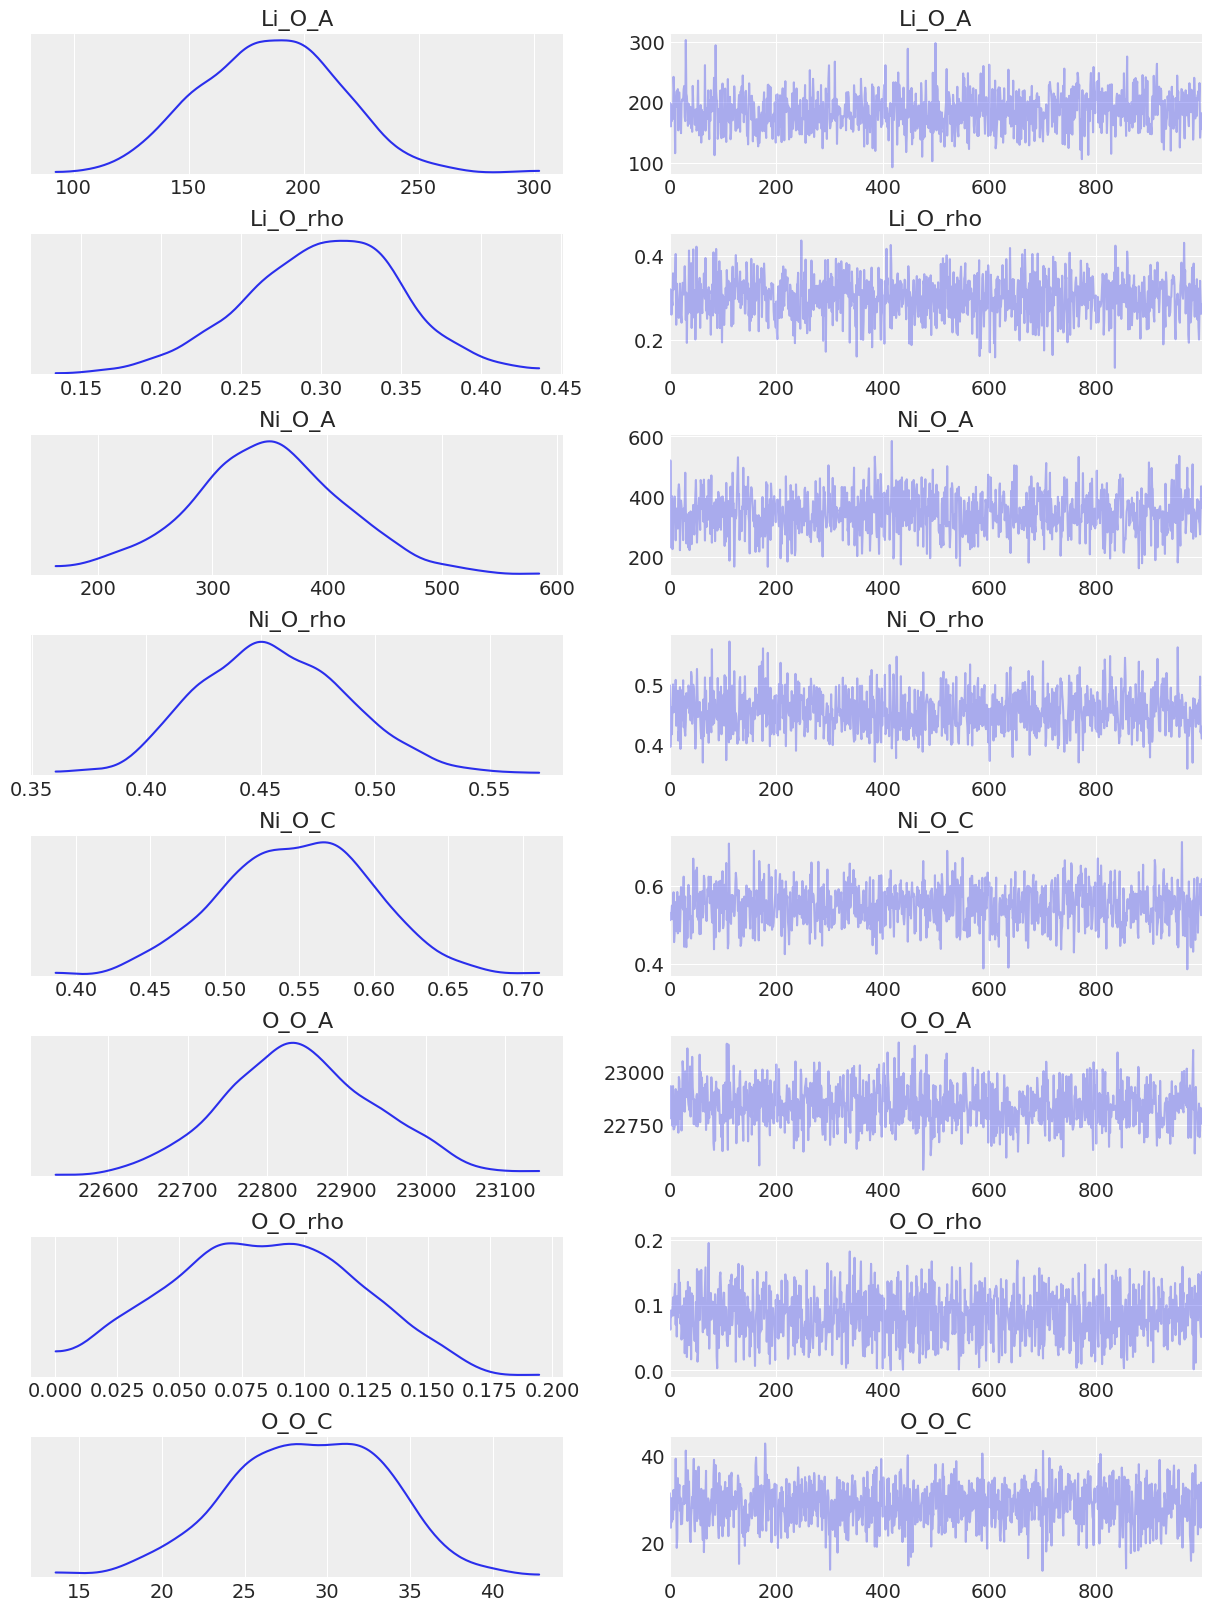

In [8]:
az.style.use('arviz-darkgrid')
az.plot_trace(trace)
plt.savefig('rigid_LiNiO2_trace.png',dpi=500, bbox_inches = "tight")

/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


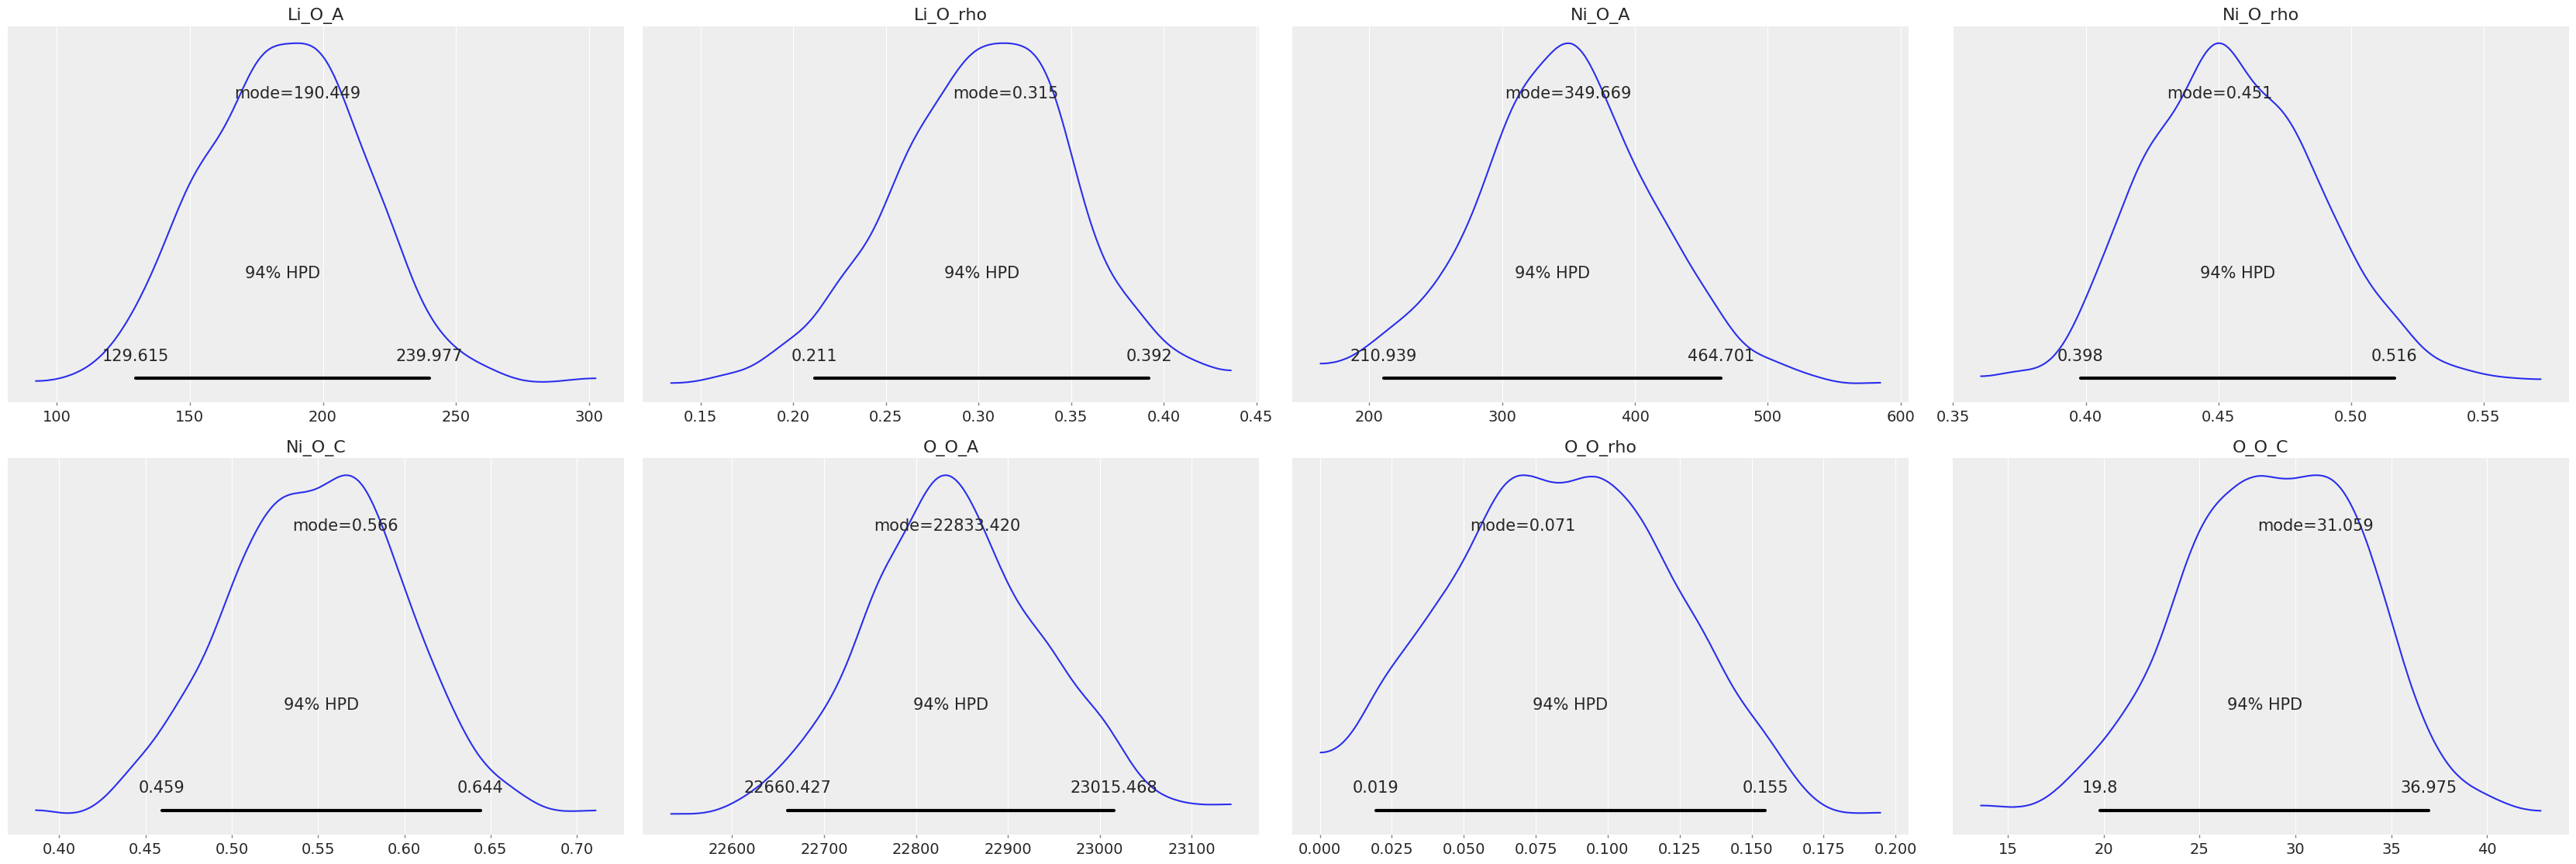

In [9]:
az.plot_posterior(trace, round_to = 3, point_estimate = 'mode')
plt.savefig('rigid_LiNiO2_mode.png',dpi=500, bbox_inches = "tight")

/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


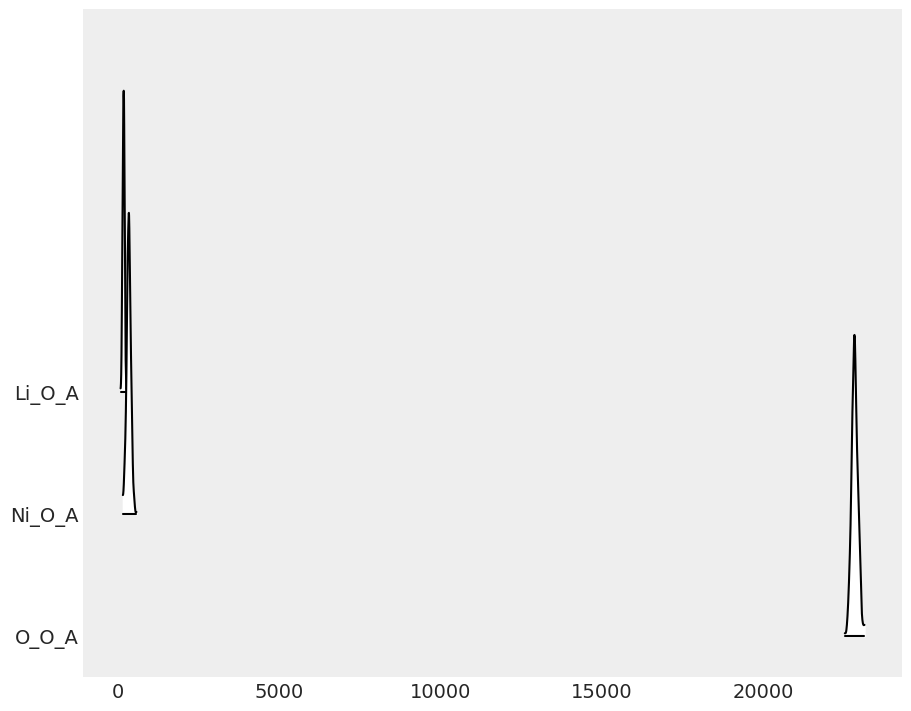

In [10]:
fig, axes = az.plot_forest(trace,
                           kind='ridgeplot',
                           var_names=['Li_O_A','Ni_O_A', 'O_O_A'],
                           combined=True,
                           ridgeplot_overlap=10,
                           colors='white',
                           figsize=(9, 7))

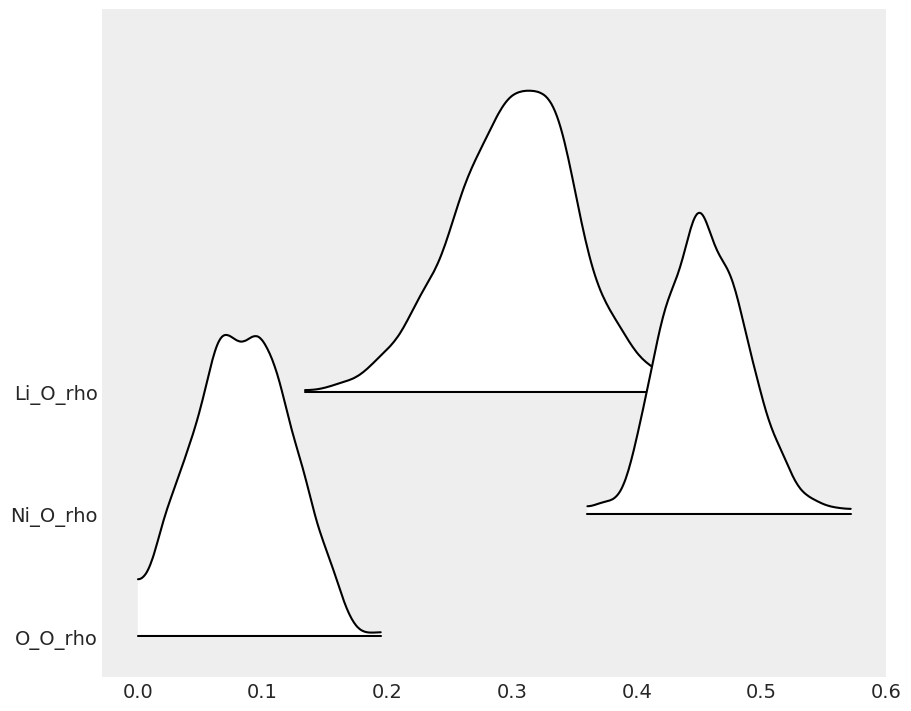

In [11]:
fig, axes = az.plot_forest(trace,
                           kind='ridgeplot',
                           var_names=['Li_O_rho','Ni_O_rho', 'O_O_rho'],
                           combined=True,
                           ridgeplot_overlap=10,
                           colors='white',
                           figsize=(9, 7))

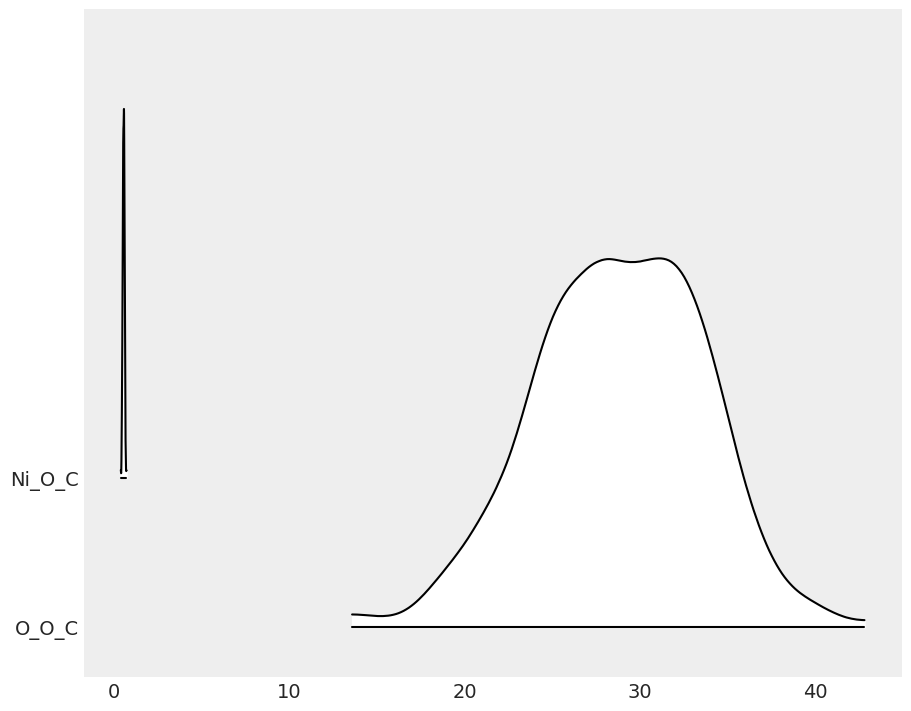

In [12]:
fig, axes = az.plot_forest(trace,
                           kind='ridgeplot',
                           var_names=['Ni_O_C', 'O_O_C'],
                           combined=True,
                           ridgeplot_overlap=10,
                           colors='white',
                           figsize=(9, 7))

In [13]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Li_O_A,185.786843,30.517293,1.071784,126.315017,241.602446
Li_O_rho,0.301509,0.048277,0.001475,0.200907,0.392085
Ni_O_A,346.982541,66.436593,2.040573,205.871763,467.904044
Ni_O_rho,0.456008,0.032860,0.001072,0.398033,0.521336
Ni_O_C,0.548520,0.050045,0.001762,0.445878,0.638694
O_O_A,22842.463167,96.552038,3.212358,22652.557225,23022.100434
O_O_rho,0.083653,0.037194,0.001172,0.015755,0.154743
O_O_C,28.818190,4.734897,0.140451,18.895419,36.876672
